In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
class Value:
    def __init__(self,data,_children=(),_op="",label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self.grad=0.0
        self.backward=lambda: None
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),"+")
        def backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out.backward=backward
        return out
    #if 1+a is called then this is called
    def __radd__(self,other):
        return self+other
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)#if non value type is tried to add to the value typ
        out=Value(self.data*other.data,(self,other),"*")
        def backward():
            self.grad+=other.data*out.grad
            other.grad=self.data*out.grad
        out.backward=backward
        return out
    #if 1*a is called then this runs
    def __rmul__(self,other):
        return self*other
    #this is for division can be directly used to divide i.e. out=Value(self.data/other.data,(self,other),"/")
    def __truediv__(self,other):
        return self*other**-1
    def __neg__(self):
        return self*-1
    def __sub__(self,other):
        return self+(-other)
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"The power must be integer or float"
        x=self.data
        out=Value(x**other,(self,),f"**{other}")
        def backward():
            self.grad+=out.grad*other*self.data**(other-1)
        out.backward=backward
        return out
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),"exp","")
        def backward():
            self.grad+=out.data*out.grad
        out.backward=backward
        return out
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),"tanh","activation")
        def backward():
            self.grad+=(1-t**2)*out.grad
        out.backward=backward
        return out
    #topological sorting 
    def back(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1
        for node in reversed(topo):
            node.backward()
        
        
        

In [3]:
a=Value(5,label="a")
b=Value(3,label='b')
c=Value(9,label='c')
d=a+b; d.label="d"
e=d*c; e.label="e"


In [4]:
e.grad=1
d.grad=9
c.grad=8
a.grad=9
b.grad=9

In [5]:
print(d._prev)


{Value(data=3), Value(data=5)}


In [6]:
from graphviz import Digraph
def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot=Digraph(format="svg",graph_attr={'rankdir':"LR"})
    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label=f"{n.label}={n.data} | grad={n.grad}", shape='record')
        if n._op:
            dot.node(name=uid+n._op,label=n._op,shape="circle")
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot


In [7]:
x1=Value(2.0,label="x1")
x2=Value(0,label="x2")
w1=Value(-3,label="w1")
w2=Value(1,label="w2")
b=Value(6.8813,label="b")

In [8]:
x1w1=x1*w1; x1w1.label="x1w1"
x2w2=x2*w2; x2w2.label="x2w2"
sxw=x1w1+x2w2;sxw.label="sxw"
z=sxw+b ; z.label="z"

In [9]:
e=(2*z).exp()
a=(e-1)/(e+1);a.label="activation"
a.back()

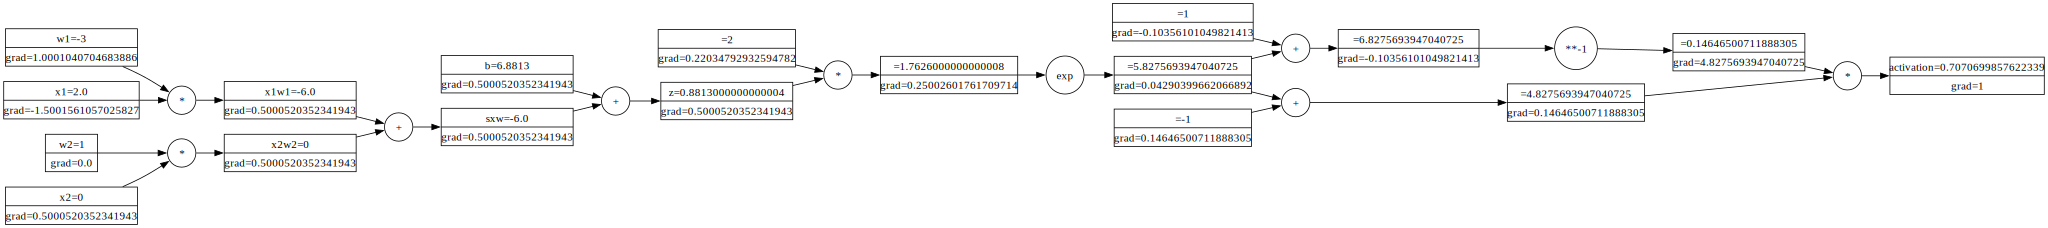

In [10]:
draw_dot(a)

In [11]:
import torch

In [12]:
x1=torch.tensor([2.0]).double(); x1.requires_grad=True
x2=torch.tensor([0]).double(); x2.requires_grad=True
w1=torch.tensor([-3]).double(); w1.requires_grad=True
w2=torch.tensor([1]).double(); w2.requires_grad=True
b=torch.tensor([6.8813]).double(); b.requires_grad=True
n=x1*w1+x2*w2+b; 
o=torch.tanh(n);
o.backward()

In [13]:
x1.data.item()

2.0

In [14]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
        z=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        a=z.tanh()
        return a
    def parameters(self):
        return self.w +[self.b]
class Layer:
    def __init__(self,nin,nout):
        self.Neurons=[Neuron(nin) for _ in range(0,nout)]
    def __call__(self,x):
        out=[n(x) for n in self.Neurons]
        return out[0] if len(out)==1 else out
    def parameters(self):
        return [p for neuron in self.Neurons for p in neuron.parameters()]
class MLP:
    def __init__(self,nin,nout):
        sz=[nin]+nout
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nout))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
p1=MLP(4,[5,4,1])
len(p1.parameters())

54

In [16]:
xs=[
    [1,-1,3,2],
    [2,3.5,1.2,0.5],
    [2,-0.5,1,-2],
    [2,4,-2.4,1]
]
ytrue=[1,0,1,0]

In [17]:
for k in range(300):
    ypred=[p1(x) for x in xs]
    loss=sum([(yhat-yout)**2 for yhat,yout in zip(ypred,ytrue)])
    for p in p1.parameters():
        p.grad=0.0
    loss.back()
    for p in p1.parameters():
        p.data-=0.01*p.grad
    print(k,loss.data)
    

0 3.2501489677062327
1 3.012579748920766
2 2.794109069923595
3 2.602498818438299
4 2.4403548954920717
5 2.306084681183026
6 2.195609597755439
7 2.1048158897429508
8 2.02938084693161
9 1.9654998897423748
10 1.9108570086809147
11 1.8631127282631903
12 1.820619657434403
13 1.7821660652851248
14 1.746638028730449
15 1.7134093958542052
16 1.6820518211982167
17 1.6519145035130292
18 1.6226267171182154
19 1.5936492331681795
20 1.5651273483493742
21 1.536441810941291
22 1.5077335657829185
23 1.4785211330652375
24 1.4489668632074642
25 1.4186371696418618
26 1.3878006829466933
27 1.3558842698085574
28 1.323061283194646
29 1.2894699830521512
30 1.2550354225893634
31 1.2198489057084547
32 1.1835281424389594
33 1.1463538834555647
34 1.1083636017216894
35 1.0700744959270665
36 1.0307623102387988
37 0.9913026592364599
38 0.9521895897067227
39 0.9130587074328644
40 0.874904853833095
41 0.8376198065816948
42 0.8018340012735972
43 0.7676183159471095
44 0.7352334287462907
45 0.7051800672087523
46 0.67741

In [18]:
ypred


[Value(data=0.9370513924273965),
 Value(data=0.40700850620077117),
 Value(data=0.544118172593918),
 Value(data=-0.033881672786288654)]

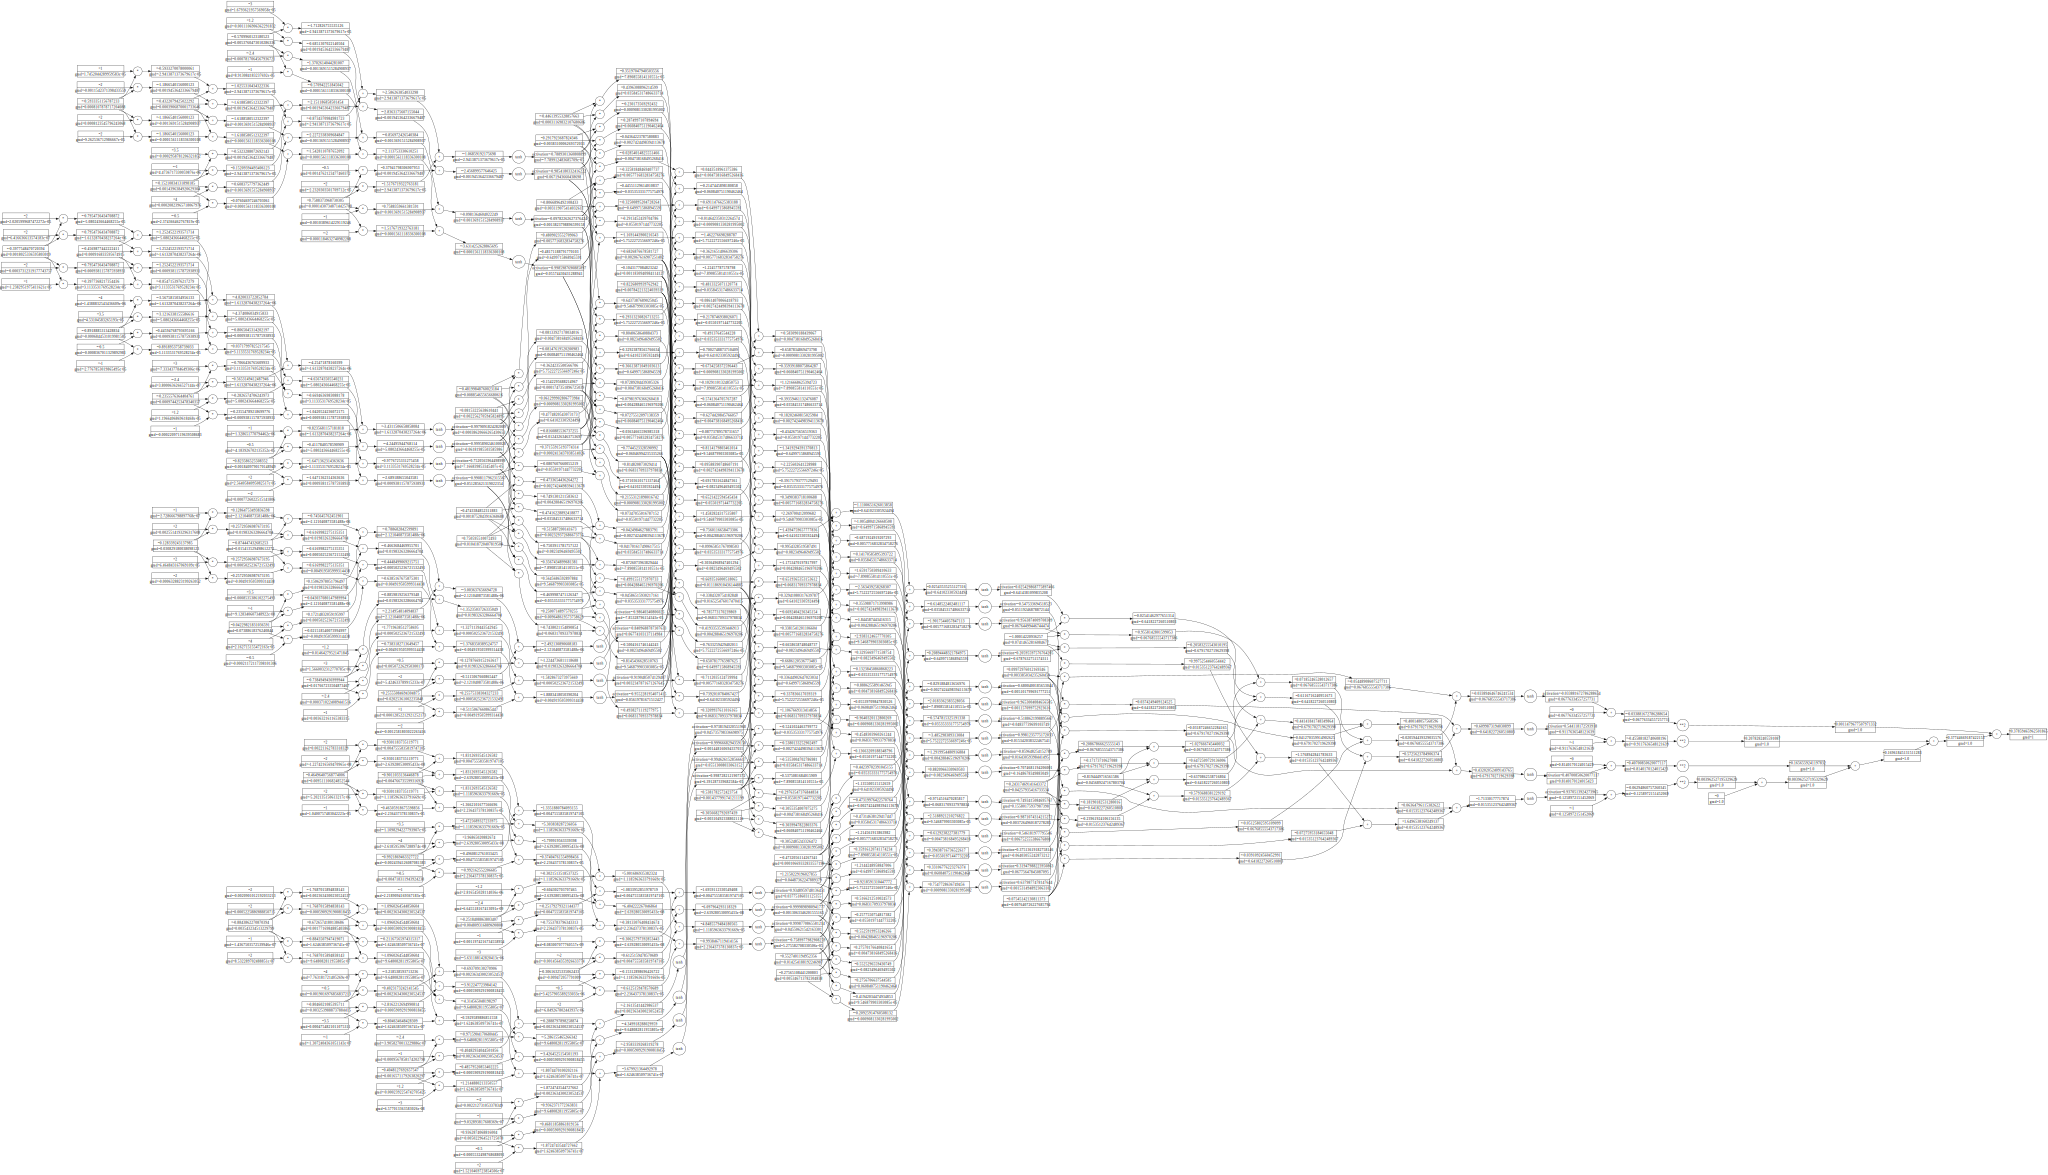

In [19]:
draw_dot(loss)